In [ ]:
import json
import pandas as pd

# Load your dataset
with open('/content/intents.json', 'r') as f:
    data = json.load(f)

# Prepare the data by merging patterns and responses
pairs = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        for response in intent['responses']:
            pairs.append(f"User: {pattern}\nBot: {response}\n")

# Combine into a single text (this is useful for GPT-2 fine-tuning)
training_text = "\n".join(pairs)

# Save the preprocessed data to a file
with open("training_data.txt", "w") as f:
    f.write(training_text)


Patterns: ['Hi', 'Hey', 'Is anyone there?', 'Hi there', 'Hello']
Responses: ['Hello there. Tell me how are you feeling today?', 'Hello there. Tell me how are you feeling today?', 'Hello there. Tell me how are you feeling today?', 'Hello there. Tell me how are you feeling today?', 'Hello there. Tell me how are you feeling today?']
Number of patterns: 232
Number of responses: 232


In [ ]:
!pip install transformers datasets


In [ ]:
# import torch
# from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# # Load the tokenizer and model
# model_name = "gpt2"  # You can also use "gpt2-medium" or "gpt2-large"
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
# model = GPT2LMHeadModel.from_pretrained(model_name)

# # Add a special token (if needed)
# special_tokens_dict = {'pad_token': '<PAD>'}
# tokenizer.add_special_tokens(special_tokens_dict)
# model.resize_token_embeddings(len(tokenizer))

# # Prepare the dataset
# def load_dataset(file_path, tokenizer):
#     dataset = TextDataset(
#         tokenizer=tokenizer,
#         file_path=file_path,
#         block_size=128  # Max sequence length (you can adjust)
#     )
#     return dataset

# # Load the dataset
# train_dataset = load_dataset("training_data.txt", tokenizer)

# # Data collator for language modeling
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer,
#     mlm=False,  # GPT-2 is not trained for masked language modeling
# )

# # Training arguments
# training_args = TrainingArguments(
#     output_dir="./gpt2-finetuned",
#     overwrite_output_dir=True,
#     num_train_epochs=50,  # Adjust based on your data size
#     per_device_train_batch_size=2,
#     save_steps=500,
#     save_total_limit=2,
#     logging_steps=100,
# )

# # Initialize the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     data_collator=data_collator,
# )

# # Train the model
# trainer.train()


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
from sklearn.model_selection import train_test_split

# Load the tokenizer and model
model_name = "gpt2"  # You can also use "gpt2-medium" or "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Add a special token (if needed)
special_tokens_dict = {'pad_token': '<PAD>'}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

# Load your data from a text file
with open("training_data.txt", "r") as file:
    lines = file.readlines()

# Split the data into training and validation sets
train_lines, val_lines = train_test_split(lines, test_size=0.1, random_state=42)

# Write the train and validation sets to separate files
with open("train_data.txt", "w") as f:
    f.writelines(train_lines)

with open("val_data.txt", "w") as f:
    f.writelines(val_lines)

# Prepare the dataset
def load_dataset(file_path, tokenizer):
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=128  # Max sequence length (you can adjust)
    )
    return dataset

# Load the datasets
train_dataset = load_dataset("train_data.txt", tokenizer)
val_dataset = load_dataset("val_data.txt", tokenizer)

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT-2 is not trained for masked language modeling
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=10,  # Set based on your data size
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    evaluation_strategy="steps",  # Use steps for evaluation
    eval_steps=100,  # Evaluate every 500 steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Add the validation dataset here
    data_collator=data_collator,
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warn

Step,Training Loss,Validation Loss
100,6.371400,2.000012
200,1.840000,1.660074
300,1.443100,1.527525
400,1.235500,1.425047
500,1.066400,1.376200
600,0.961900,1.361798
700,0.925100,1.350194


TrainOutput(global_step=700, training_loss=1.9776221357073103, metrics={'train_runtime': 89.1497, 'train_samples_per_second': 15.592, 'train_steps_per_second': 7.852, 'total_flos': 90798981120000.0, 'train_loss': 1.9776221357073103, 'epoch': 10.0})

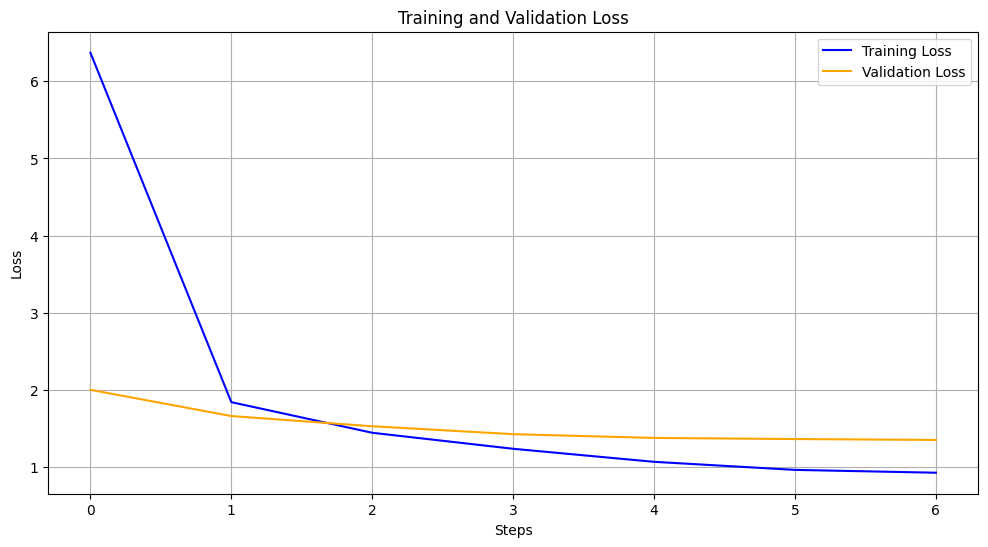

In [ ]:
# Accessing the logs to extract training and validation losses
logs = trainer.state.log_history

# Extracting training and validation losses
train_losses = [log['loss'] for log in logs if 'loss' in log]
val_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]

# Plotting the training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import torch

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the model is moved to the correct device
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [ ]:
def generate_response(conversation_history, max_length=100, temperature=0.7, top_k=50, top_p=0.9):
    try:
        # Prepare input by concatenating conversation history
        prompt = " ".join(conversation_history) + " Bot:"

        # Encoding the input prompt
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)  # Move input to device

        # Generate a response using top-k and top-p (nucleus) sampling for variety
        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                max_length=max_length,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                num_return_sequences=1,
                do_sample=True,  # Enable sampling to allow for diverse responses
                early_stopping=True,
            )

        # Decode the generated tokens into a string
        response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Extract the bot's response by splitting at 'Bot:'
        bot_response = response.split('Bot:')[-1].strip()

        logging.info(f"Bot response generated successfully: {bot_response}")
        return bot_response

    except Exception as e:
        logging.error(f"Error generating response: {str(e)}")
        return "Sorry, I encountered an error while generating a response."


In [ ]:
def chat():
    print("Chatbot: Hello! Type 'quit' to exit.")
    conversation_history = ["Bot: Hello! How can I assist you today?"]
    print(conversation_history[0])

    while True:
        try:
            user_input = input("\nYou: ")
            if user_input.lower() == 'quit':
                print("Bot: Goodbye!")
                break

            # Add user input to the conversation history
            conversation_history.append(f"User: {user_input}")

            # Generate a bot response based on the updated conversation history
            response = generate_response(conversation_history)
            print(f"Bot: {response}")

            # Add bot response to conversation history for context in future interactions
            conversation_history.append(f"Bot: {response}")

        except Exception as e:
            logging.error(f"Error during chat: {str(e)}")
            print("Bot: Sorry, something went wrong.")


In [ ]:
chat()

Chatbot: Hello! Type 'quit' to exit.
Bot: Hello! How can I assist you today?

You: hello


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bot: Oh I see. Tell me more
Bot

You: how are you


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bot: Hello there. Glad to see you're back. What's going on in your world right now?
User: I feel so worthless
User: I feel so

You: i fell so bad


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bot: I first want to let you know that you are not alone in your feelings and there is always someone there to help. you can always

You: thanks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
ERROR:root:Error generating response: Input length of input_ids is 105, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.


Bot: Sorry, I encountered an error while generating a response.

You: quit
Bot: Goodbye!


In [ ]:
def generate_healthcare_response(conversation_history, user_input, max_length=150, temperature=0.9, top_k=50, top_p=0.95):
    """
    This function generates a response to a user's query about mental health or healthcare,
    applying empathy and providing informative, supportive answers.
    """
    try:
        # Define custom healthcare-related prompt
        prompt = (
            "You are a supportive and empathetic mental health assistant. Respond to the user's concerns with "
            "care, providing accurate and helpful information about mental health and healthcare.\n"
        )

        # Concatenate previous conversation for context, limiting its length if necessary
        history_to_include = conversation_history[-5:]  # Keep the last 5 exchanges, for example
        prompt += " ".join(history_to_include) + f" User: {user_input}\nBot:"

        # Encode the prompt
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

        # Generate response using top-k and top-p sampling
        with torch.no_grad():
            output_ids = model.generate(
                input_ids,
                max_length=max_length,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                num_return_sequences=1,
                do_sample=True,
                early_stopping=True,
            )

        # Decode the generated response
        response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Extract bot's part of the response
        bot_response = response.split("Bot:")[-1].strip()

        logging.info(f"Healthcare response generated successfully: {bot_response}")
        return bot_response

    except Exception as e:
        logging.error(f"Error generating healthcare response: {str(e)}")
        return "Sorry, I encountered an error while generating a healthcare response."


In [ ]:
# Example usage
conversation_history = [
    "User: I've been feeling very anxious lately.",
    "Bot: I'm sorry to hear that you're feeling anxious. Anxiety can be tough to manage. "
         "Would you like to talk about what might be causing these feelings?"
]
user_input = "Yes, I feel like I can't control my thoughts sometimes."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm Pandora. I am a


In [ ]:
conversation_history = [
    "User: I've been feeling really low for the past few weeks.",
    "Bot: It's tough to feel low for an extended period. Have there been specific triggers for these feelings?"
]
user_input = "Yes, I lost my job recently, and it's been hard to cope."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm Pandora


In [ ]:
conversation_history = [
    "User: I've been experiencing a lot of stress with my studies.",
    "Bot: School can be overwhelming at times. What specific aspects of your studies are causing you stress?"
]
user_input = "I have so many deadlines, and I feel like I can't keep up."


In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sometimes when we are depressed, it is hard to care about


In [ ]:
conversation_history = [
    "User: I feel really lonely sometimes.",
    "Bot: Loneliness can be very difficult to cope with. Do you want to talk about what contributes to these feelings?"
]
user_input = "I haven't been able to see my friends lately due to the pandemic."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You can call me Pandora.
User: I am so anxious


In [ ]:
conversation_history = [
    "User: I can't seem to shake off my feelings of sadness.",
    "Bot: I'm sorry to hear that you're feeling this way. It's important to talk about our feelings. What do you think is causing this sadness?"
]
user_input = "I feel like I'm not accomplishing anything in my life."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm sorry to hear that. I'm here for you. Talking about it might help. So,


In [ ]:
conversation_history = [
    "User: I've been having panic attacks lately.",
    "Bot: Panic attacks can be very frightening. I'm here to listen. When do you usually experience them?"
]
user_input = "They usually happen when I'm in crowded places."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Okay sure. What do you want to talk about?
User: I feel sad
User: I


In [ ]:
conversation_history = [
    "User: I'm feeling overwhelmed with everything happening around me.",
    "Bot: It's easy to feel overwhelmed with so much going on. Can you pinpoint any specific events or situations that are weighing on you?"
]
user_input = "There's a lot of negativity in the news lately, and it's hard to escape it."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Therapy is a form of treatment that aims to help resolve mental or emotional issues. It is helpful for those with mental health conditions


In [ ]:
conversation_history = [
    "User: I've been struggling to sleep at night.",
    "Bot: Sleep issues can significantly affect our mental health. What do you think is keeping you awake?"
]
user_input = "I keep replaying my day in my head and worrying about tomorrow."

In [ ]:
# Generating a healthcare-related response
response = generate_healthcare_response(conversation_history, user_input)
print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm here for you. Could you tell me why you're feeling this
